In [43]:
from pyspark.sql import SparkSession
from pathlib import Path
import pyspark.sql.functions as func
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum


def read_parquet_file(spark, file_path):
    df = spark.read.parquet(file_path)
    return df


def is_hdfs_file_exist(path):
    proc = subprocess.Popen(['hadoop', 'fs', '-test', '-e', path])
    proc.communicate()
    return proc.returncode == 0


def add_index_to_dataframe(df):
    return df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))



spark = SparkSession.builder.appName('lr_example').getOrCreate()

# Load data
hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"
case_file_dest = "case_daily_summary.parquet"

all_data = read_parquet_file(spark, hdfs_host+hdfs_root_path+case_file_dest)
all_data.printSchema()



root
 |-- date: string (nullable = true)
 |-- dailyConfirmed: integer (nullable = true)



In [44]:
cases_group_by_date = all_data.withColumn("dayOfWeek", func.dayofweek(all_data["date"]))
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()
cases_group_by_date.printSchema()

+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-01-23|             1|        5|    1|
|2020-01-24|             2|        6|    2|
|2020-01-25|             1|        7|    3|
|2020-01-26|             0|        1|    4|
|2020-01-27|             1|        2|    5|
|2020-01-28|             2|        3|    6|
|2020-01-29|             3|        4|    7|
|2020-01-30|             3|        5|    8|
|2020-01-31|             3|        6|    9|
|2020-02-01|             2|        7|   10|
|2020-02-02|             0|        1|   11|
|2020-02-03|             0|        2|   12|
|2020-02-04|             6|        3|   13|
|2020-02-05|             4|        4|   14|
|2020-02-06|             2|        5|   15|
|2020-02-07|             3|        6|   16|
|2020-02-08|             7|        7|   17|
|2020-02-09|             3|        1|   18|
|2020-02-10|             2|        2|   19|
|2020-02-11|             2|     

Text(0, 0.5, 'Count')

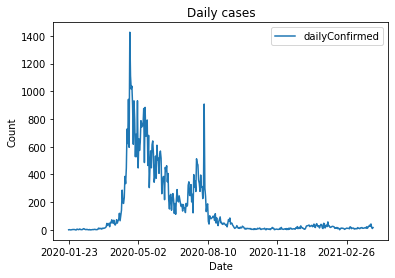

In [45]:
cases_group_by_date.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")

+---------+-------------------+
|dayOfWeek|sum(dailyConfirmed)|
+---------+-------------------+
|        1|               8823|
|        2|               8083|
|        3|               8105|
|        4|               9512|
|        5|               8698|
|        6|               9152|
|        7|               8202|
+---------+-------------------+



<AxesSubplot:>

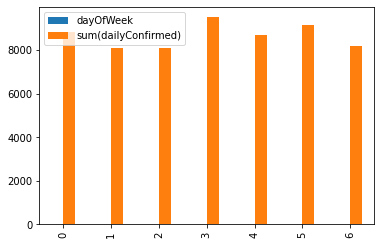

In [53]:

#cases_group_by_date.select("count").distinct().show()
cases_group_by_day_of_week = cases_group_by_date\
                        .groupby(['dayOfWeek'])\
                        .agg(_sum('dailyConfirmed'))\
                        .orderBy('dayOfWeek',asending=True)
cases_group_by_day_of_week.show()

cases_group_by_day_of_week.toPandas().plot(kind='bar')


In [48]:
# Split into training data and test data
total_count = cases_group_by_date.count()
seventy_percent_index = round(total_count * 0.7)
cases_group_by_date.registerTempTable("daily_cases")
train_data = spark.sql("select * from daily_cases where index <= {}".format(seventy_percent_index))
test_data = spark.sql("select * from daily_cases where index > {}".format(seventy_percent_index))
train_data.show()
test_data.show()

+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-01-23|             1|        5|    1|
|2020-01-24|             2|        6|    2|
|2020-01-25|             1|        7|    3|
|2020-01-26|             0|        1|    4|
|2020-01-27|             1|        2|    5|
|2020-01-28|             2|        3|    6|
|2020-01-29|             3|        4|    7|
|2020-01-30|             3|        5|    8|
|2020-01-31|             3|        6|    9|
|2020-02-01|             2|        7|   10|
|2020-02-02|             0|        1|   11|
|2020-02-03|             0|        2|   12|
|2020-02-04|             6|        3|   13|
|2020-02-05|             4|        4|   14|
|2020-02-06|             2|        5|   15|
|2020-02-07|             3|        6|   16|
|2020-02-08|             7|        7|   17|
|2020-02-09|             3|        1|   18|
|2020-02-10|             2|        2|   19|
|2020-02-11|             2|     

In [49]:
# These are the default values for the featuresCol, labelCol, predictionCol
vectorAssembler = VectorAssembler(inputCols=["index","dayOfWeek"], outputCol="features")
train_sub = vectorAssembler.transform(train_data)
test_sub = vectorAssembler.transform(test_data)

lr = LinearRegression(featuresCol='features',labelCol='dailyConfirmed',predictionCol='prediction')
# Fit the model
lr_model = lr.fit(train_sub)
# Print the coefficients and intercept training data
print("Coefficients: {}".format(str(lr_model.coefficients)))
print("Intercept: {}".format(str(lr_model.intercept)))

Coefficients: [-0.5713947662047318,0.3125169026119389]
Intercept: 276.52648534273567


In [50]:
# Testing result
test_result = lr_model.evaluate(test_sub)
test_result.residuals.show()
print("RMSE: {}".format(test_result.rootMeanSquaredError))

+------------------+
|         residuals|
+------------------+
|  -94.786964962126|
|-96.52808709853323|
|-97.26920923494043|
|-95.01033137134763|
|-90.56383518947129|
|-93.30495732587846|
|-88.04607946228569|
|-95.78720159869289|
|-88.52832373510012|
|-94.26944587150729|
|-84.01056800791451|
|-89.56407182603814|
|-81.30519396244534|
|-82.04631609885257|
|-87.78743823525977|
|  -87.528560371667|
|-85.26968250807417|
| -85.0108046444814|
|-83.56430846260503|
|-85.30543059901223|
+------------------+
only showing top 20 rows

RMSE: 53.03950558002016


In [51]:
# Prediction
predictions = lr_model.transform(test_sub)
predictions = predictions.withColumn("prediction",func.round(predictions["prediction"]))
predictions.show()


+----------+--------------+---------+-----+-----------+----------+
|      date|dailyConfirmed|dayOfWeek|index|   features|prediction|
+----------+--------------+---------+-----+-----------+----------+
|2020-11-25|             7|        4|  308|[308.0,4.0]|     102.0|
|2020-11-26|             5|        5|  309|[309.0,5.0]|     102.0|
|2020-11-27|             4|        6|  310|[310.0,6.0]|     101.0|
|2020-11-28|             6|        7|  311|[311.0,7.0]|     101.0|
|2020-11-29|             8|        1|  312|[312.0,1.0]|      99.0|
|2020-11-30|             5|        2|  313|[313.0,2.0]|      98.0|
|2020-12-01|            10|        3|  314|[314.0,3.0]|      98.0|
|2020-12-02|             2|        4|  315|[315.0,4.0]|      98.0|
|2020-12-03|             9|        5|  316|[316.0,5.0]|      98.0|
|2020-12-04|             3|        6|  317|[317.0,6.0]|      97.0|
|2020-12-05|            13|        7|  318|[318.0,7.0]|      97.0|
|2020-12-06|             5|        1|  319|[319.0,1.0]|      9

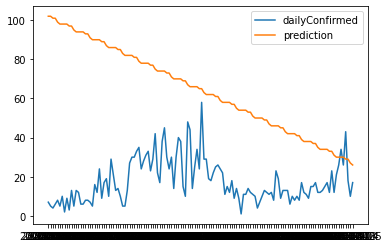

In [52]:
predictionsPandas = predictions.toPandas()

plt.plot( 'date', 'dailyConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction', data=predictionsPandas, marker='')

# show legend
plt.legend()
# show graph
plt.show()
